# Check on the files exported by Equivital Qiosk
for RITMO

TODO

Plot and review measurements from equivital sensors as output by the Equivital Manager app.
(Every program produces different formated files and it's a pain.)

In [189]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import heartpy as hp

from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

## Definitions for data extraction

In [190]:
%load_ext autoreload
%autoreload 1
%aimport qex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
%reload_ext autoreload

In [131]:
# running on mac
seperator = '/'
seperator

'/'

In [167]:
pwd

'/Users/finn/Desktop/Current_Projects/Trial_sensors/qiosk_processing'

In [83]:
seperator = str('//')
seperator

'//'

# Scan for DATA files in Qiosk exported files
Check the usual spot that QIOSK deposits files for data files detailing recordings

In [ ]:
# location of the files when exported by QIOSK
path = "C:\\Users\\Public\\Documents\\Equivital\\Equivital Manager Wizard\\"#Extracted SEM Data\\" #"../Equivital/Equivital Manager Wizard/Extracted SEM Data/"
#os.listdir(path)

In [168]:
path = '/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/'
a = qex.qiosk_recordings(path,'Present',seperater)
a

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,BR604,5022198,230213,0,DATA-BR604-5022198-23021300.CSV,csv,6574,2023-02-13 19:52:49+00:00,2023-02-13 20:12:34+00:00,...,[BR604],5022198.0,BR604,NaN,108,73.0,1.0,1.0,Stationary,Side


In [169]:
seperater = '/'
df_datafiles = qex.qiosk_recordings(path,'Present',seperater)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,BR604,5022198,230213,0,DATA-BR604-5022198-23021300.CSV,csv,6574,2023-02-13 19:52:49+00:00,2023-02-13 20:12:34+00:00,...,[BR604],5022198.0,BR604,NaN,108,73.0,1.0,1.0,Stationary,Side


In [171]:
eq_file_loc = df_datafiles.loc[0,'FullLoc']
qex.min_dets(eq_file_loc,seperator)

{'Signal': 'DATA',
 'DevName': 'BR604',
 'ID': 5022198,
 'Date': 230213,
 'Session': 0,
 'FileName': 'DATA-BR604-5022198-23021300.CSV',
 'FileType': 'csv',
 'FileSize': 6574,
 'FullLoc': '/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/DATA-BR604-5022198-23021300.CSV'}

In [172]:
proj_name = 'test'
df_datafiles = qex.qiosk_recordings(path,proj_name,seperator)
df_datafiles

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,BR604,5022198,230213,0,DATA-BR604-5022198-23021300.CSV,csv,6574,2023-02-13 19:52:49+00:00,2023-02-13 20:12:34+00:00,...,[BR604],5022198.0,BR604,NaN,108,73.0,1.0,1.0,Stationary,Side


In [173]:
# key categories to structure of Qiosk output DATA files
print('Number of DATA files: '+ str(len(df_datafiles)))
print(df_datafiles['ID'].unique())
print(df_datafiles['Date'].unique())

Number of DATA files: 1
[5022198]
[230213]


### OR scan files from a project folder outside of the automatic qiosk export folders

In [164]:
# location of the files when in one of the local project files
projectName = 'MusiciansPilot' # this needs to match the project folder name
path = "C:\\Users\\fourMs lab\\Documents\\Equivital\\ProjectData\\"+projectName+"\\"#Extracted SEM Data\\" #"../Equivital/Equivital Manager Wizard/Extracted SEM Data/"
#os.listdir(path)

df_datafiles = qex.qiosk_recordings(path,projectName,seperator)
df_datafiles

TypeError: qiosk_recordings() missing 1 required positional argument: 'sep'

In [174]:
# key categories to structure of Qiosk output DATA files
print('Number of DATA files: '+ str(len(df_datafiles)))
print(df_datafiles['ID'].unique())
print(df_datafiles['Date'].unique())

Number of DATA files: 1
[5022198]
[230213]


# Review recordings from a specific device and recording time
First preview files from a specific device (or other feild), then find the other signal files that match that Data files

In [175]:
# DATA files from one device, by the more reliable device ID numbr
devN = 5022198
s_files=df_datafiles.loc[df_datafiles['ID'] == devN,:] 
#s_files=df_datafiles.loc[df_datafiles['Date'] == 230127,:]

# t = pd.to_datetime('2023-01-27 10:30:00.00+0000')# V['DateTime'].iloc[int(len(V)/2)]
# s_files=s_files.loc[s_files['RecStart']< t,:] 
s_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,BR604,5022198,230213,0,DATA-BR604-5022198-23021300.CSV,csv,6574,2023-02-13 19:52:49+00:00,2023-02-13 20:12:34+00:00,...,[BR604],5022198.0,BR604,NaN,108,73.0,1.0,1.0,Stationary,Side


In [176]:
fileN = 0
eq_file_loc = s_files.loc[fileN,'FullLoc']
print(s_files.loc[fileN,:])

Signal                                                            DATA
DevName                                                          BR604
ID                                                             5022198
Date                                                            230213
Session                                                              0
FileName                               DATA-BR604-5022198-23021300.CSV
FileType                                                           csv
FileSize                                                          6574
RecStart                                     2023-02-13 19:52:49+00:00
RecEnd                                       2023-02-13 20:12:34+00:00
Duration                                                        1185.0
BatteryStart                                                      4065
BatteryEnd                                                        4029
BatteryChange(mV)                                                  -36
FullLo

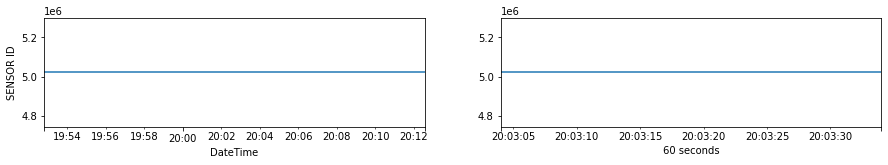

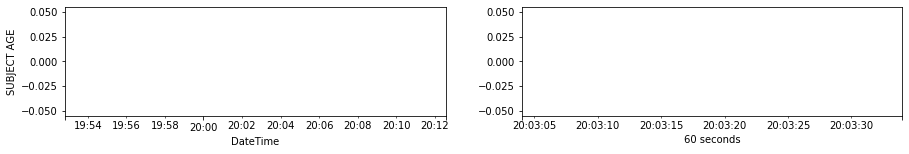

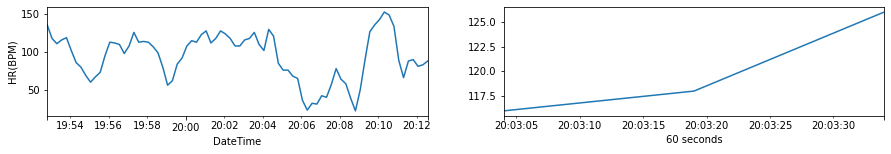

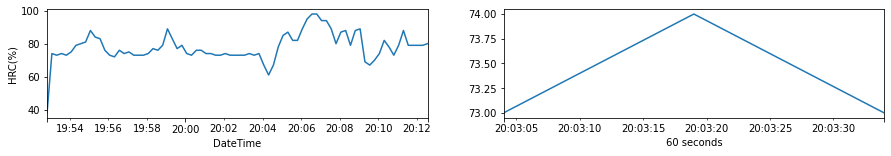

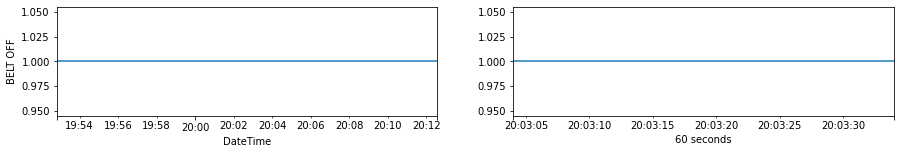

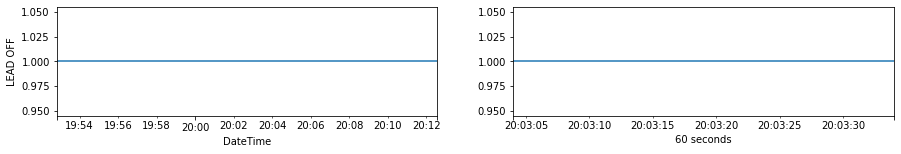

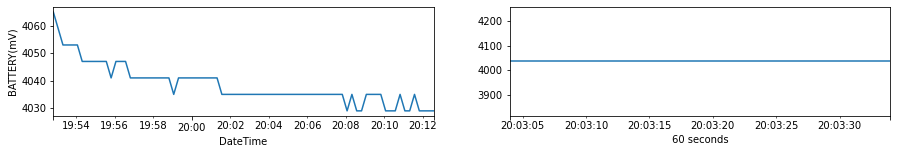

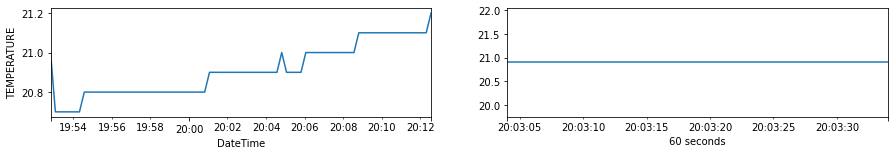

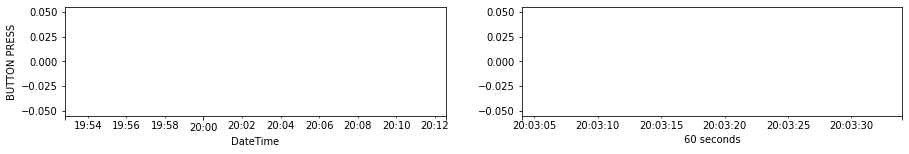

,DateTime,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION,BATTERY(mV),TEMPERATURE,BUTTON PRESS
0,2023-02-13 19:52:49+00:00,5022198,BR604,NaN,136,38,1,1,Stationary,Side,4065,21.0,NaN
1,2023-02-13 19:53:04+00:00,5022198,BR604,NaN,118,74,1,1,Stationary,Side,4059,20.7,NaN
2,2023-02-13 19:53:19+00:00,5022198,BR604,NaN,111,73,1,1,Stationary,Side,4053,20.7,NaN
3,2023-02-13 19:53:34+00:00,5022198,BR604,NaN,116,74,1,1,Stationary,Side,4053,20.7,NaN
4,2023-02-13 19:53:49+00:00,5022198,BR604,NaN,119,73,1,1,Stationary,Side,4053,20.7,NaN


In [177]:
# Plot a quick view of the DATA file numeric fields
V = pd.read_csv(eq_file_loc,skipinitialspace=True)
qex.test_plot_signals(V)
V.iloc[:5]

Now grab all the files from that recording and presente a test plot of each, full and middle minute


In [178]:
s_files

,Signal,DevName,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
0,DATA,BR604,5022198,230213,0,DATA-BR604-5022198-23021300.CSV,csv,6574,2023-02-13 19:52:49+00:00,2023-02-13 20:12:34+00:00,...,[BR604],5022198.0,BR604,NaN,108,73.0,1.0,1.0,Stationary,Side


In [179]:
eq_file_loc ='/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/FASTACC-BR604-5022198-23021300.CSV'
w = eq_file_loc.split(seperator)
file_name = w[-1]
f = file_name.split('-')
f
#w[-2].lower().startswith('csv')

['FASTACC', 'BR604', '5022198', '23021300.CSV']

In [182]:
matched = qex.matched_files(s_files.loc[fileN,'FullLoc'],path,seperator) # outputs locations of csv 
matched

['/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/FASTACC-BR604-5022198-23021300.CSV',
 '/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/DATA-BR604-5022198-23021300.CSV',
 '/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/ECG-BR604-5022198-23021300.csv',
 '/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/RESPACC-BR604-5022198-23021300.CSV',
 '/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/RR-BR604-5022198-23021300.CSV',
 '/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/SEM/BR604/23021300.SEM']

In [183]:
eq_file_loc

'/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/CSV/FASTACC-BR604-5022198-23021300.CSV'

In [184]:
Session = int(f[3][6:8])
os.path.getsize(eq_file_loc)

13657430

In [185]:
pwd

'/Users/finn/Desktop/Current_Projects/Trial_sensors/qiosk_processing'

Index(['DateTime', 'Vert Accelerometer', 'Lat Accelerometer',
       'Long Accelerometer'],
      dtype='object')


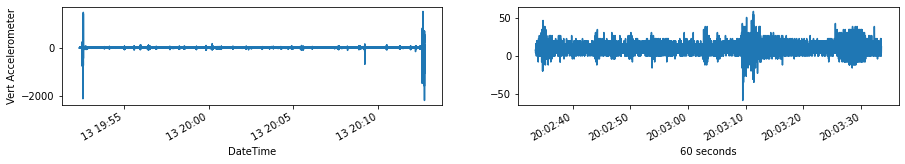

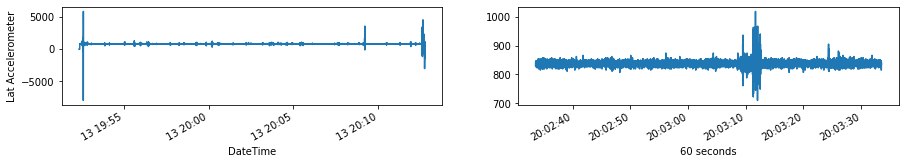

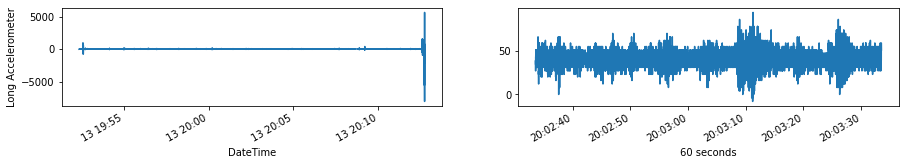

Index(['DateTime', 'SENSOR ID', 'SUBJECT ID', 'SUBJECT AGE', 'HR(BPM)',
       'HRC(%)', 'BELT OFF', 'LEAD OFF', 'MOTION', 'BODY POSITION',
       'BATTERY(mV)', 'TEMPERATURE', 'BUTTON PRESS'],
      dtype='object')


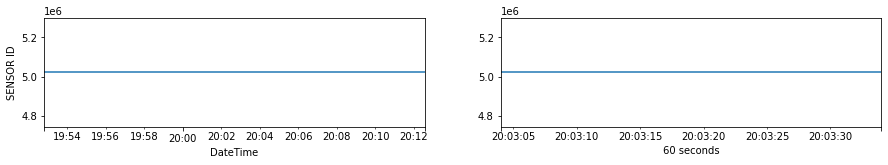

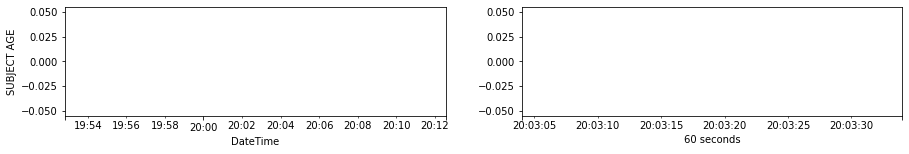

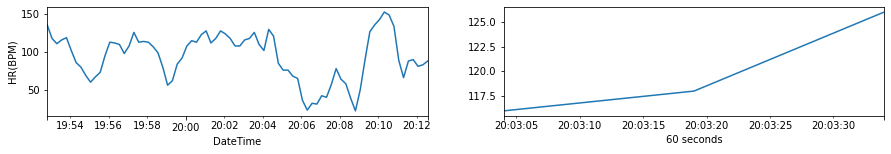

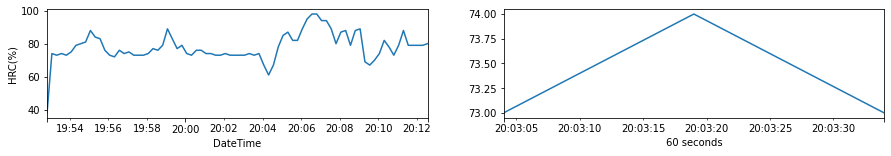

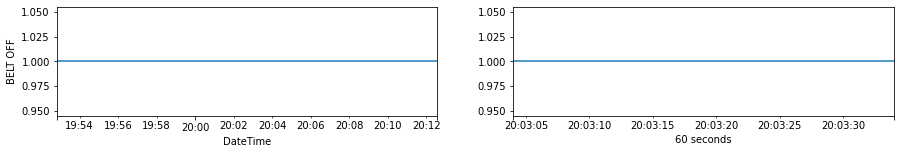

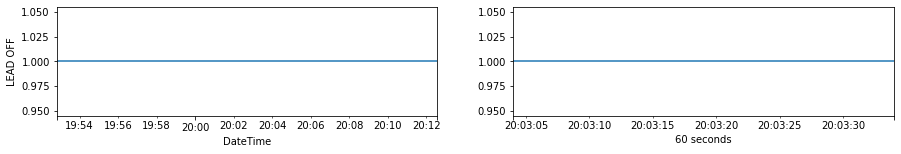

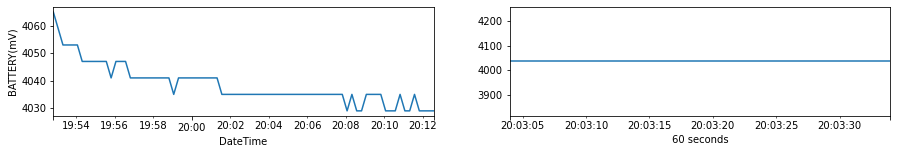

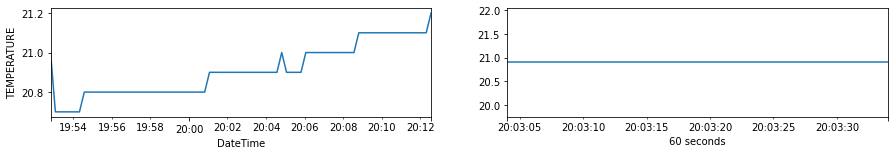

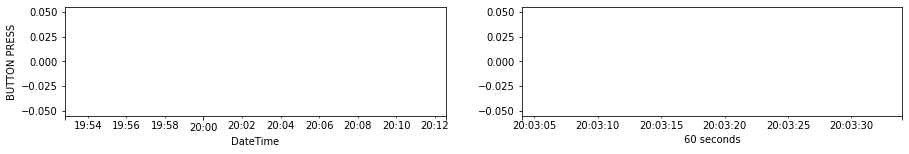

Index(['DateTime', 'Lead 1', 'Lead 2'], dtype='object')


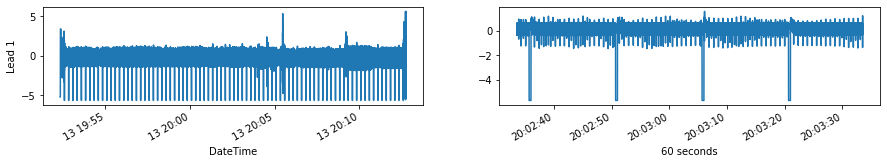

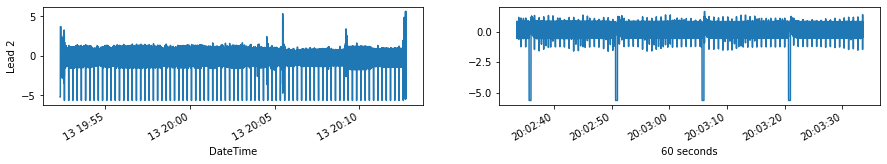

Index(['DateTime', 'Breathing'], dtype='object')


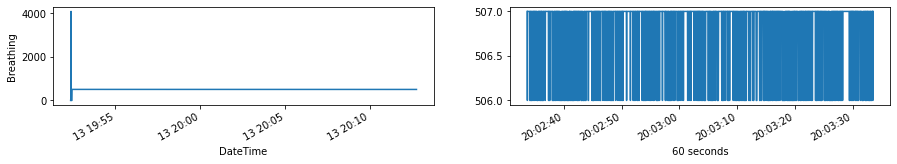

Index(['DateTime', 'Interbeat Interval (MS)'], dtype='object')


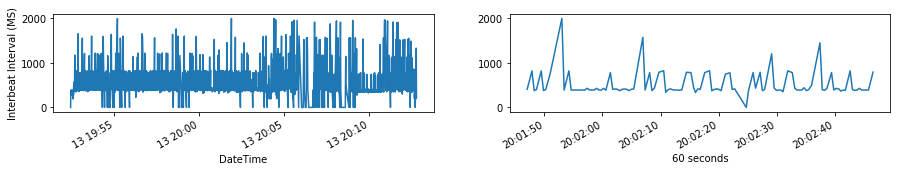

In [186]:
matched = qex.matched_files(s_files.loc[fileN,'FullLoc'],path,seperator) # outputs locations of csv 
for eq_file_loc in matched:
    if not eq_file_loc.lower().endswith('.sem'):
        V = pd.read_csv(eq_file_loc,skipinitialspace=True)
        print(V.columns)
        qex.test_plot_signals(V)

# Plot all signals recorded at specific time

In [187]:
#fileN = 
eq_file_loc = df_datafiles.loc[fileN,'FullLoc']
print(df_datafiles.loc[fileN,:])

Signal                                                            DATA
DevName                                                          BR604
ID                                                             5022198
Date                                                            230213
Session                                                              0
FileName                               DATA-BR604-5022198-23021300.CSV
FileType                                                           csv
FileSize                                                          6574
RecStart                                     2023-02-13 19:52:49+00:00
RecEnd                                       2023-02-13 20:12:34+00:00
Duration                                                        1185.0
BatteryStart                                                      4065
BatteryEnd                                                        4029
BatteryChange(mV)                                                  -36
FullLo

# the times at which you want to check the recording
# note: make sure you set the times to within the recording interval for that file!!
t1 = pd.to_datetime('2023-02-13 09:50:00.00+0000')# V['DateTime'].iloc[int(len(V)/2)]
t2 = t1+pd.to_timedelta(240,'s')
[t1,t2]

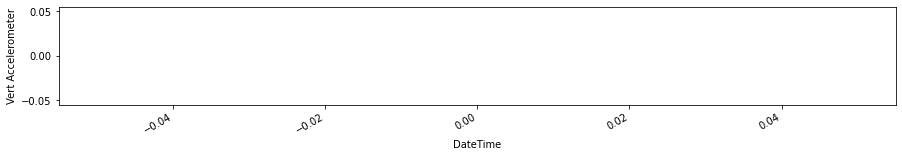

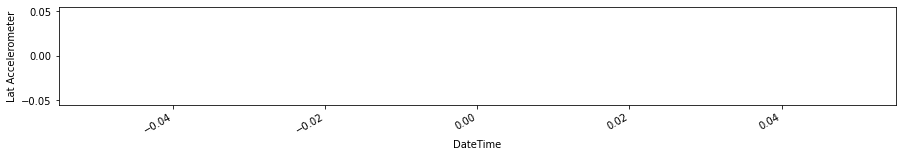

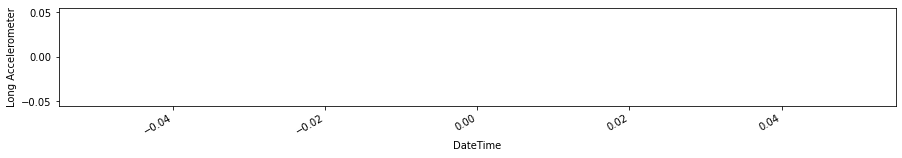

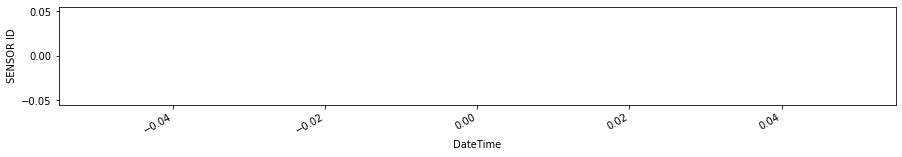

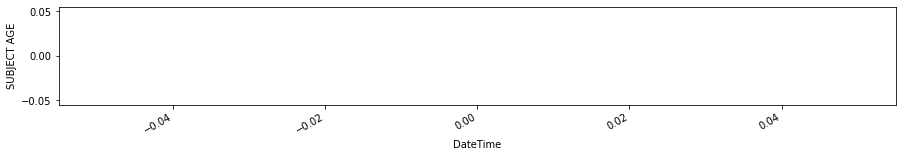

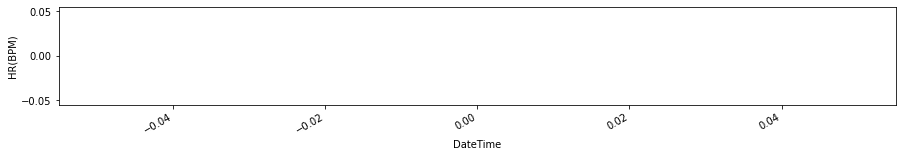

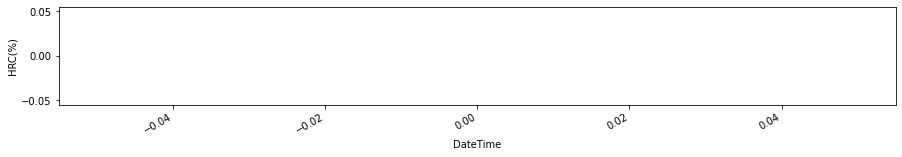

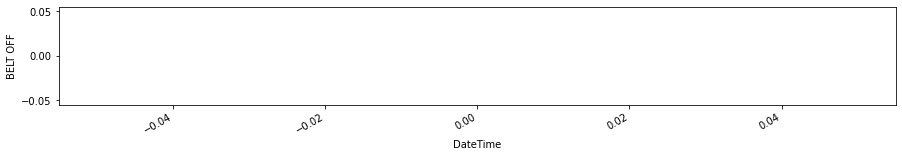

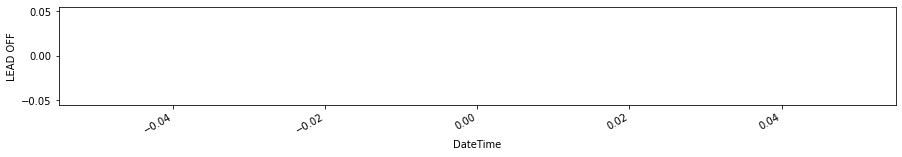

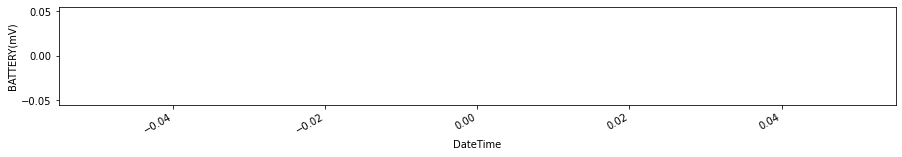

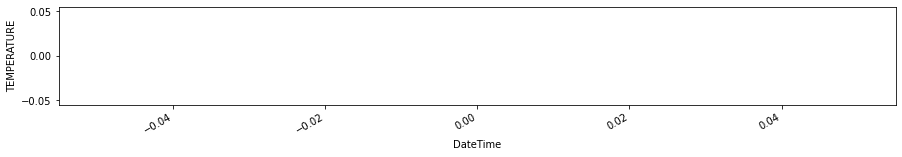

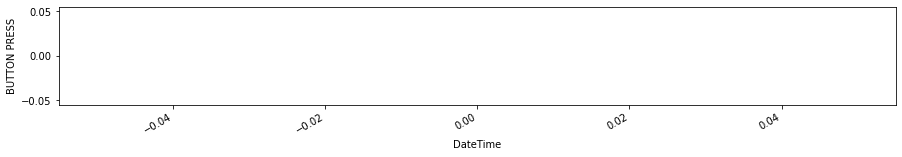

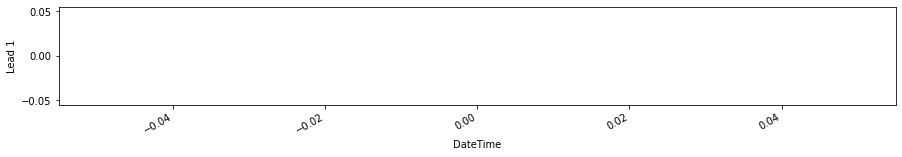

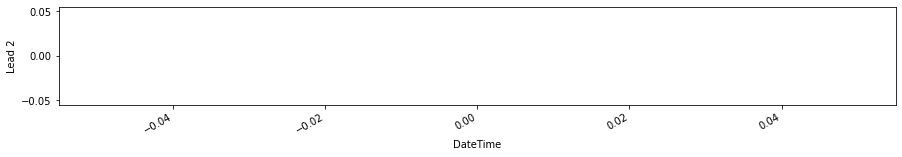

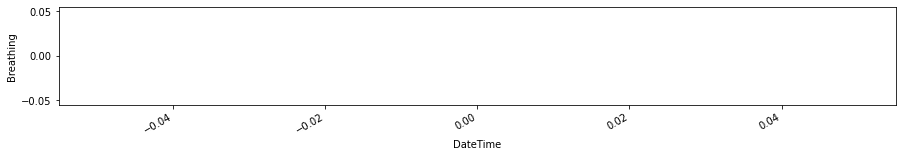

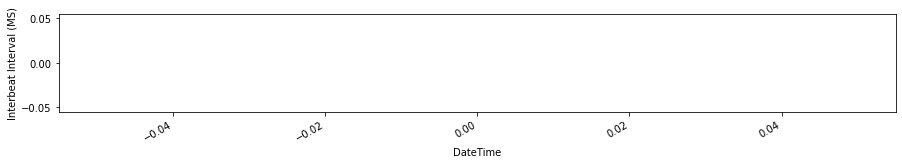

FileNotFoundError: [Errno 2] No such file or directory: '/Users/finn/Desktop/Current_Projects/Trial_sensors/Equivital/BR604/SEM/BR604/23021300.SEM'

In [188]:
for eq_file_loc in matched:
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
#     print(V.iloc[:2,:])
    qex.test_plot_signals_interval(V,t1,t2)

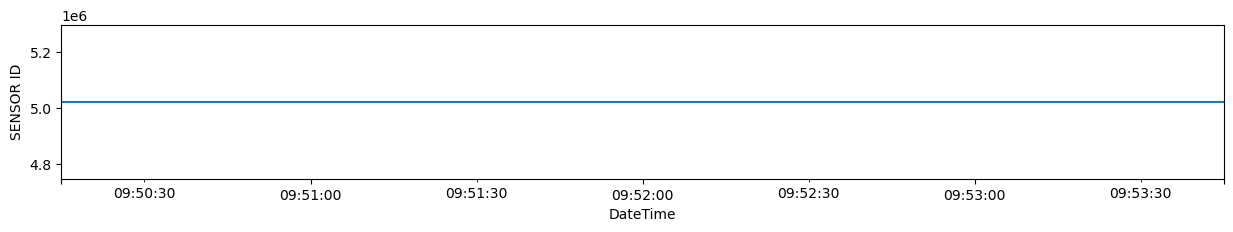

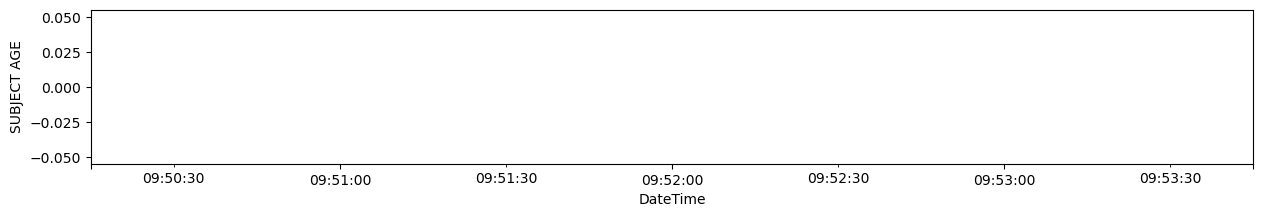

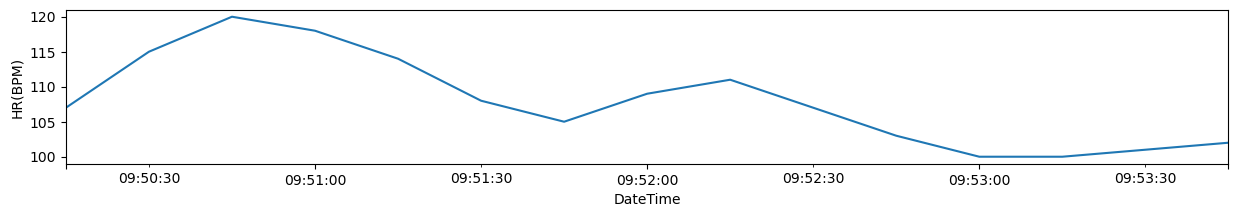

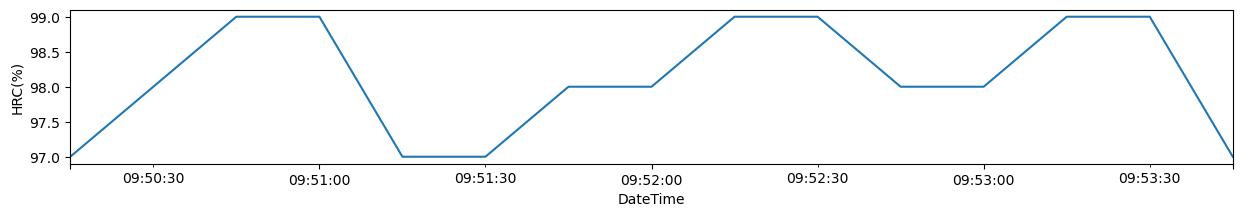

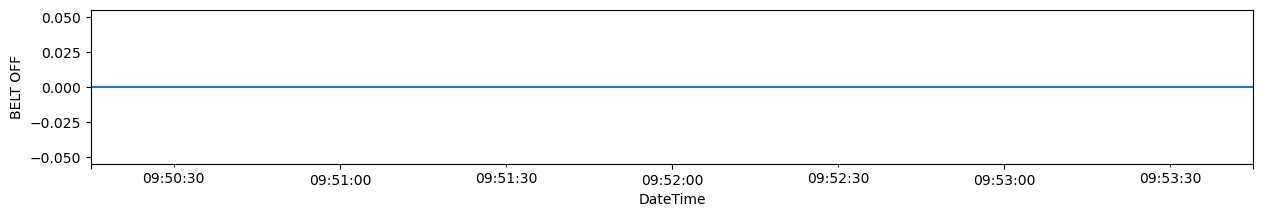

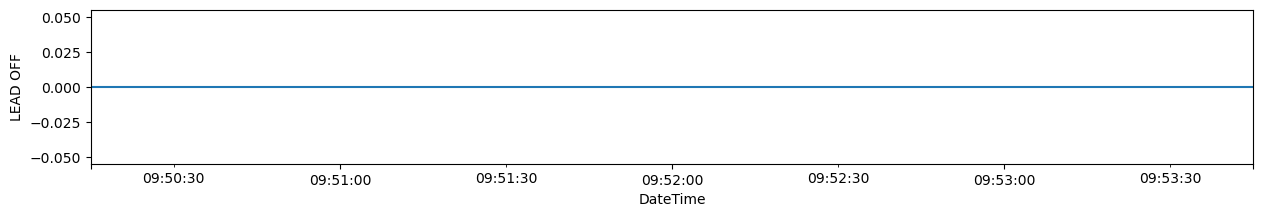

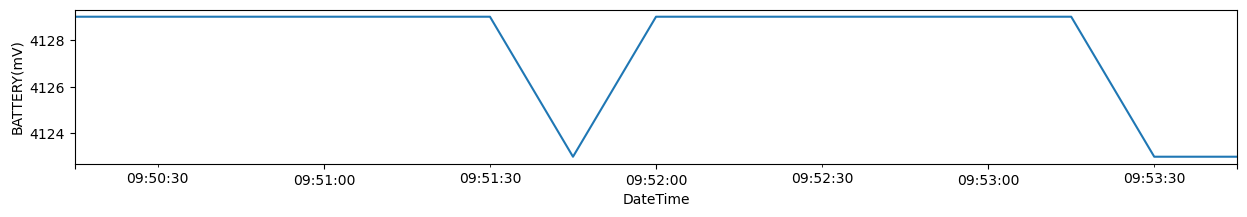

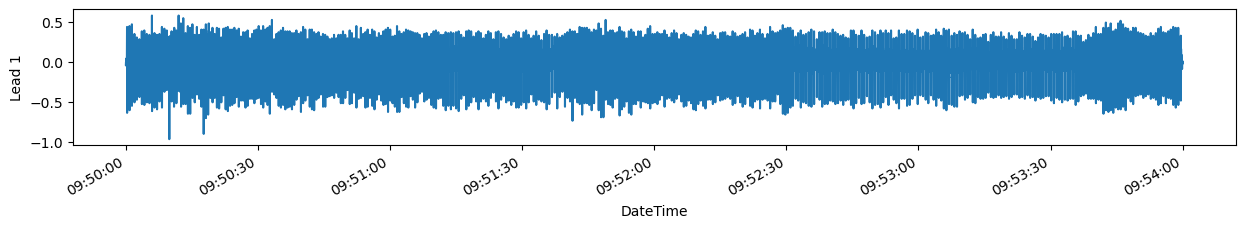

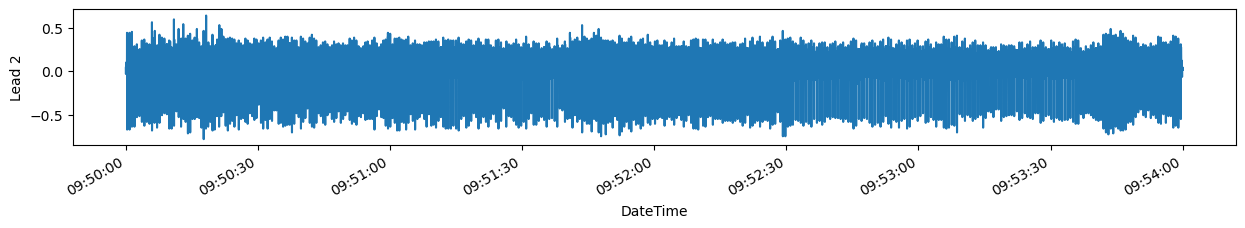

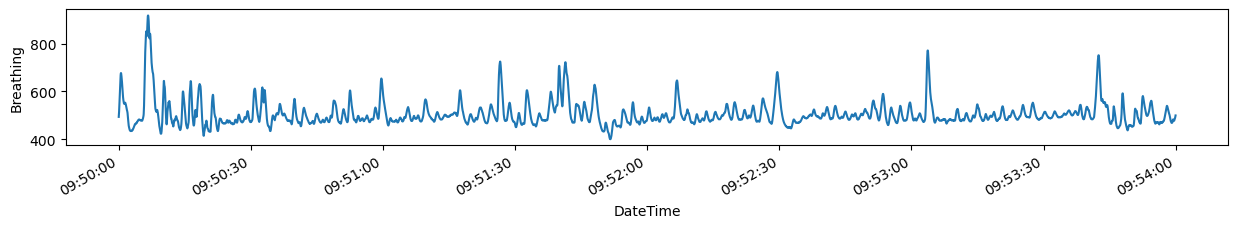

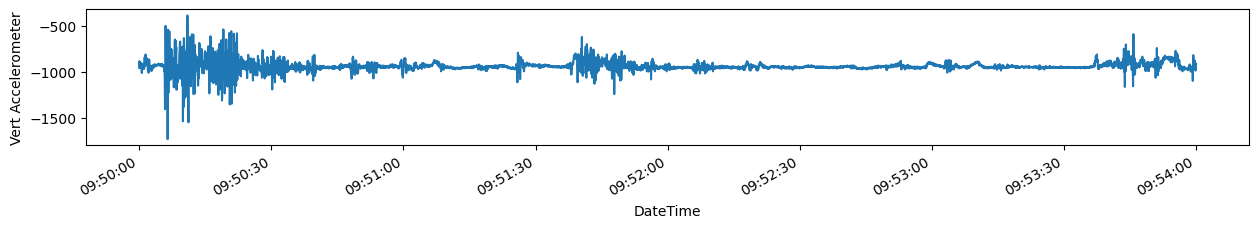

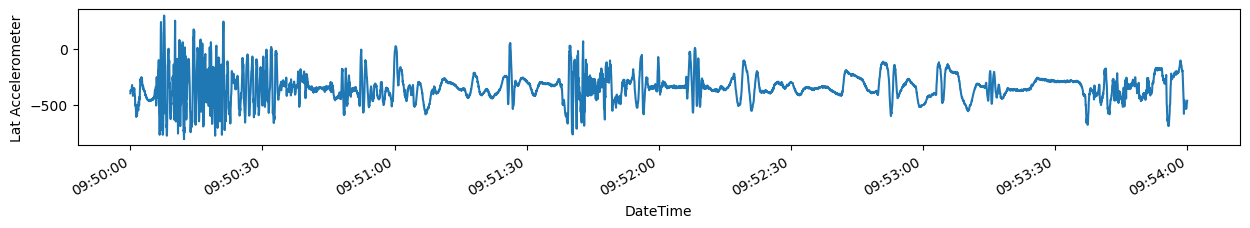

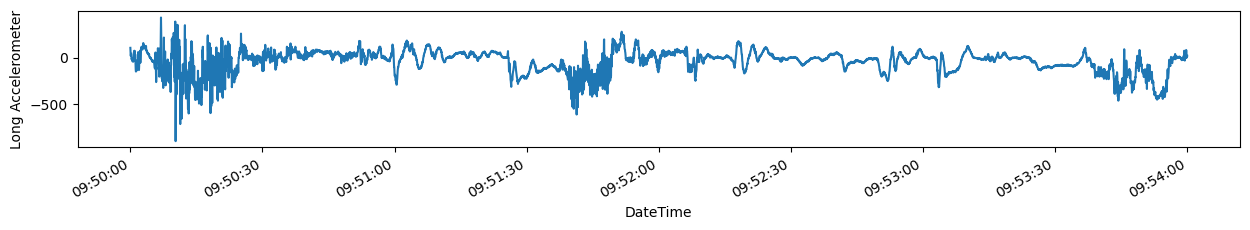

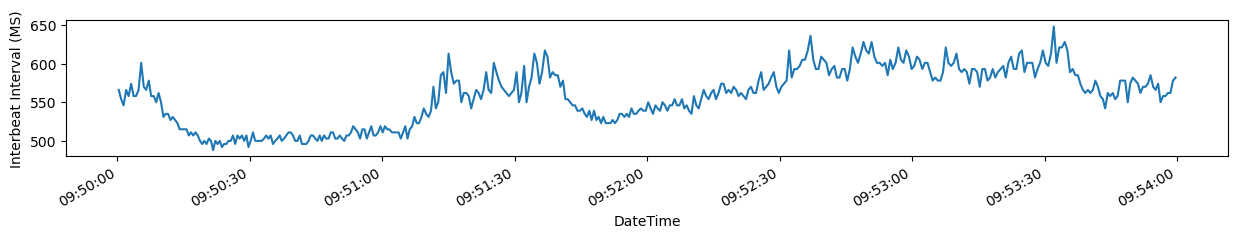

No data


In [104]:
# to save exported plots
plotname = 'ViolinPlayingPilot'
for eq_file_loc in matched:
    V = pd.read_csv(eq_file_loc,skipinitialspace=True)
#     print(V.iloc[:2,:])
    qex.test_plot_signals_interval_save(V,t1,t2,plotname)

In [45]:
eq_file_loc

'C:\\Users\\fourMs lab\\Documents\\Equivital\\ProjectData\\SoloRecordings\\SEM\\Pilot_1\\23020100_1.SEM'